In [1]:
import sys
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models import autoencoderV8
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH
import os

Using TensorFlow backend.
W0423 10:32:10.988192 140578162960192 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length))
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j] in self.aa_order:
                    result[i, j] = self.aa_order.index(X[i][j]) + 1
                else:
                    result[i, j] = len(self.aa_order)
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [4]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [5]:
encoder, autoencoder, sess = autoencoderV8(21, latent_dim=50)

W0423 10:32:30.886687 140578162960192 deprecation_wrapper.py:76] From ../models/RNN_autoencoder8.py:24: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0423 10:32:30.887360 140578162960192 deprecation_wrapper.py:76] From ../models/RNN_autoencoder8.py:25: The name Session is deprecated. Please use compat.v1.Session instead.

W0423 10:32:31.022714 140578162960192 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0423 10:32:31.025224 140578162960192 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name random_uniform is deprecated. Please use random.uniform instead.

W0423 10:32:31.030791 140578162960192 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1228: The name 

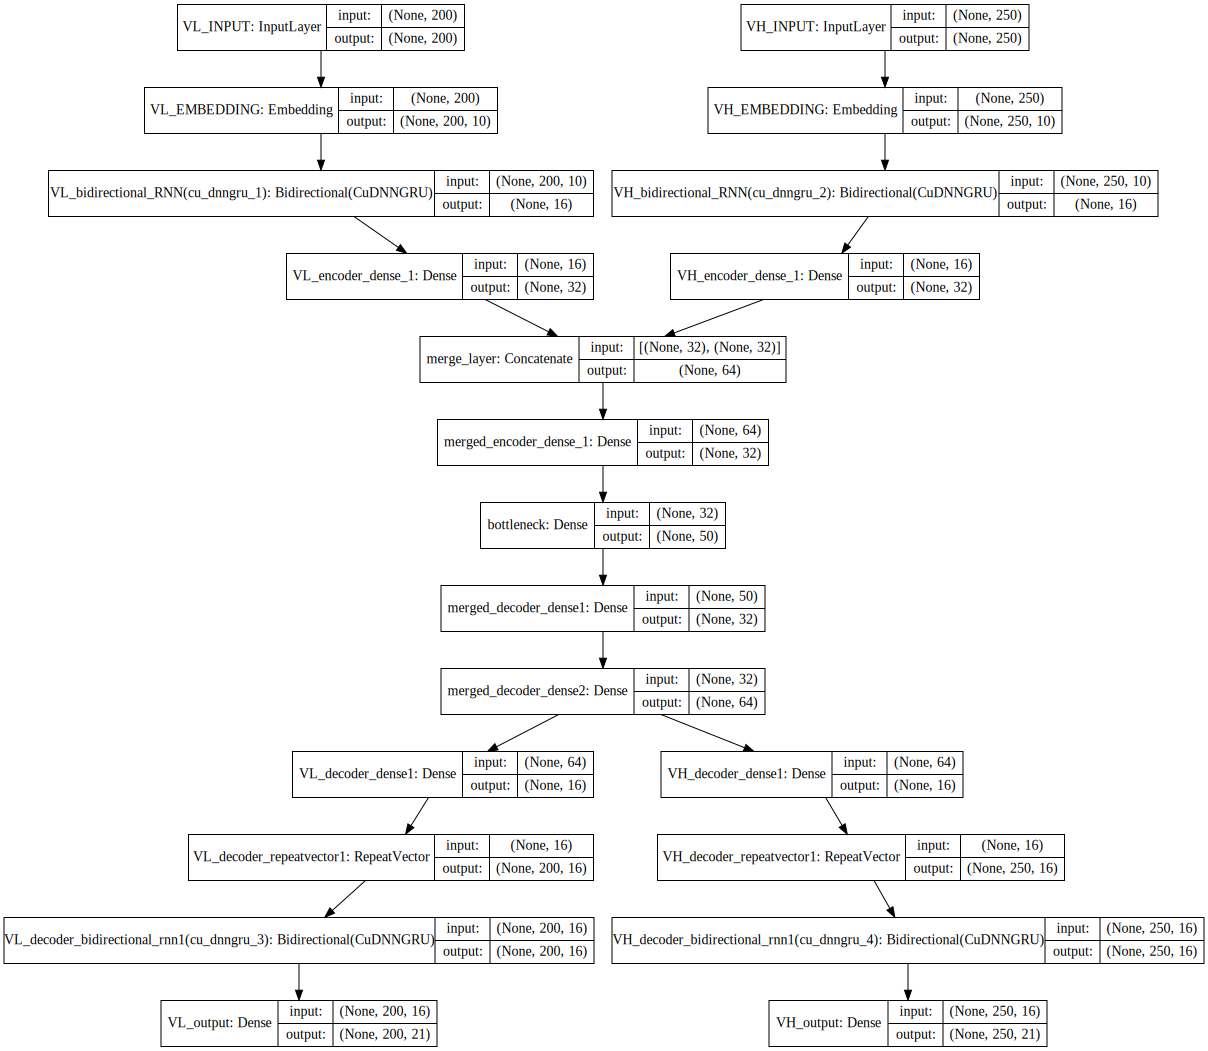

In [6]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
NAME= 'autoencoderV8_raw'
RUN = 'run1'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [8]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [9]:
from keras import backend as K

In [10]:
VL_encoded_shuffled_ohe = np.eye(21)[VL_encoded_shuffled.astype('int32')]
VH_encoded_shuffled_ohe = np.eye(21)[VH_encoded_shuffled.astype('int32')]

In [11]:
VL_encoded_shuffled_ohe.shape

(5180, 200, 21)

In [12]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.variable(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
#         y_true = K.reshape(y_true, y_pred.get_shape().as_list()[:2])
        y_true = keras.layers.Reshape((y_pred.get_shape().as_list()[-2],))(y_true)
        mask = K.equal(y_true, mask_value)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.cast(y_true, 'int64'), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=K.get_session().run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled_ohe[:1]})

In [13]:
r

2.12317

In [14]:
def acc(y_true, y_pred):
    y_true = keras.layers.Reshape((y_pred.get_shape().as_list()[-2],))(y_true)
    mask = K.equal(y_true, 0)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.cast(y_true, 'int64'), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [15]:
K.get_session().run(acc(lhs,rhs), feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled_ohe[:1]})

1.0

In [16]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=get_loss(0), metrics=[acc])

In [17]:
class CosineAnnealingAdaptiveLRScheduler(keras.callbacks.Callback):

    """
    Keras adaptive learning scheduler implementation of cosine annealing
    that resets every cycle. A cycle unit is defined as the number of
    batches per epoch. The cycle can then be adjusted by a scalar after
    each cycle ending
    """

    def __init__(self, lr=None, cycle_len=1, cycle_mult=2):

        """
        CosineAnnealingAdaptiveLRScheduler constructor.
        Args:
            lr: base learning rate. If set to None it will be inferred from the model optimiser.
            cycle_len: initial cycle length. If set to 1 it will be equivalent to the number of batches per epoch
            cycle_mult: scalar to adjust cycle length at the end of each epoch
        """

        super(CosineAnnealingAdaptiveLRScheduler, self).__init__()

        self.lr = lr
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.iteration = 0
        self.steps_per_epoch = None
        self.current_cycle_iterations = None

    def on_batch_begin(self, epoch, logs=None):

        """
        Callback to adjust the learning rate at the start of each batch
        Args:
            epoch:
            logs:
        Returns:
        """

        if self.current_cycle_iterations < self.iteration:
            # update cycle length
            self.cycle_len *= self.cycle_mult
            self.current_cycle_iterations = self._get_iter_per_cycle()
            # reset state to start new cycle
            self._reset()

        # cosine annealing -> the self.current_cycle_iterations+1 avoids cos(pi) which is 0
        new_lr = (np.cos(self.iteration / (self.current_cycle_iterations + 1) * np.pi) + 1) * self.lr

        K.set_value(self.model.optimizer.lr, new_lr)

#         print('\nIteration {}/{}: {}\n'.format(self.iteration, self.current_cycle_iterations, new_lr))

        self.iteration += 1

    def _get_iter_per_cycle(self):
        """
        Calculate the number of iterations in current cycle
        Returns:
        """
        return self.steps_per_epoch * self.cycle_len

    # adapted from https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def on_train_begin(self, logs=None):
        """
        Sets some attributes that can only be inferred at model runtime.
        Args:
            logs:
        Returns:
        """
        if self.lr is None:
            self.lr = K.get_value(self.model.optimizer.lr)
        self.steps_per_epoch = self._autodetect_steps_per_epoch()
        self.current_cycle_iterations = self.steps_per_epoch * self.cycle_len

        # compensates for cosine annealing -> could divide by 2 at each step, or just do it here
        self.lr /= 2

    # https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def _autodetect_steps_per_epoch(self):
        """
        Determine the number of steps per epoch.
        Returns:
        """
        if self.params.get('steps'):
            # The number of steps is provided in the parameters.
            return self.params['steps']
        elif self.params.get('samples') and self.params.get('batch_size'):
            # Compute the number of steps per epoch using # of samples and a batch size.
            return self.params['samples'] // self.params['batch_size']
        else:
            raise ValueError('Could not autodetect the number of steps per epoch. '
                             'Please specify the steps_per_epoch parameter to the '
                             '%s() or upgrade to the latest version of Keras.'
                             % self.__class__.__name__)

    def _reset(self):
        """
        Reset the state of the learning rate to start a new cycle.
        Returns:
        """
        self.iteration = 0

In [ ]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[CosineAnnealingAdaptiveLRScheduler(lr=0.01, cycle_len=2, cycle_mult=2),
                                     keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples
Epoch 1/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.6372 - VL_output_loss: 2.7964 - VH_output_loss: 2.8408 - VL_output_acc: 0.1493 - VH_output_acc: 0.1247 - val_loss: 5.5501 - val_VL_output_loss: 2.7621 - val_VH_output_loss: 2.7880 - val_VL_output_acc: 0.1522 - val_VH_output_acc: 0.1413
Epoch 2/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 5.5314 - VL_output_loss: 2.7569 - VH_output_loss: 2.7745 - VL_output_acc: 0.1528 - VH_output_acc: 0.1363 - val_loss: 5.5236 - val_VL_output_loss: 2.7519 - val_VH_output_loss: 2.7717 - val_VL_output_acc: 0.1563 - val_VH_output_acc: 0.1374
Epoch 3/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.4800 - VL_output_loss: 2.7316 - VH_output_loss: 2.7484 - VL_output_acc: 0.1521 - VH_output_acc: 0.1426 - val_loss: 5.4173 - val_VL_output_loss: 2.6972 - val_VH_output_loss: 2.7202 - val_VL_output_acc: 0.1586 - val_VH_output_acc: 0.1500
Epoc

Epoch 27/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.6470 - VL_output_loss: 2.2992 - VH_output_loss: 2.3478 - VL_output_acc: 0.2504 - VH_output_acc: 0.2519 - val_loss: 4.6437 - val_VL_output_loss: 2.2958 - val_VH_output_loss: 2.3480 - val_VL_output_acc: 0.2532 - val_VH_output_acc: 0.2545
Epoch 28/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.6389 - VL_output_loss: 2.2955 - VH_output_loss: 2.3434 - VL_output_acc: 0.2508 - VH_output_acc: 0.2545 - val_loss: 4.6384 - val_VL_output_loss: 2.2929 - val_VH_output_loss: 2.3455 - val_VL_output_acc: 0.2520 - val_VH_output_acc: 0.2573
Epoch 29/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.6356 - VL_output_loss: 2.2938 - VH_output_loss: 2.3418 - VL_output_acc: 0.2508 - VH_output_acc: 0.2551 - val_loss: 4.6367 - val_VL_output_loss: 2.2922 - val_VH_output_loss: 2.3444 - val_VL_output_acc: 0.2513 - val_VH_output_acc: 0.2576
Epoch 30/5000
4144/4144 [========================

Epoch 53/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3824 - VL_output_loss: 2.1478 - VH_output_loss: 2.2347 - VL_output_acc: 0.3386 - VH_output_acc: 0.2944 - val_loss: 4.3957 - val_VL_output_loss: 2.1598 - val_VH_output_loss: 2.2359 - val_VL_output_acc: 0.3326 - val_VH_output_acc: 0.3006
Epoch 54/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3752 - VL_output_loss: 2.1444 - VH_output_loss: 2.2309 - VL_output_acc: 0.3429 - VH_output_acc: 0.2978 - val_loss: 4.3751 - val_VL_output_loss: 2.1421 - val_VH_output_loss: 2.2330 - val_VL_output_acc: 0.3424 - val_VH_output_acc: 0.2969
Epoch 55/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3699 - VL_output_loss: 2.1412 - VH_output_loss: 2.2286 - VL_output_acc: 0.3441 - VH_output_acc: 0.2982 - val_loss: 4.3712 - val_VL_output_loss: 2.1407 - val_VH_output_loss: 2.2305 - val_VL_output_acc: 0.3405 - val_VH_output_acc: 0.3017
Epoch 56/5000
4144/4144 [========================

Epoch 79/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3132 - VL_output_loss: 2.1176 - VH_output_loss: 2.1956 - VL_output_acc: 0.3381 - VH_output_acc: 0.3091 - val_loss: 4.3976 - val_VL_output_loss: 2.2143 - val_VH_output_loss: 2.1833 - val_VL_output_acc: 0.2740 - val_VH_output_acc: 0.3257
Epoch 80/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3060 - VL_output_loss: 2.1088 - VH_output_loss: 2.1972 - VL_output_acc: 0.3425 - VH_output_acc: 0.3086 - val_loss: 4.3257 - val_VL_output_loss: 2.1149 - val_VH_output_loss: 2.2108 - val_VL_output_acc: 0.3386 - val_VH_output_acc: 0.3079
Epoch 81/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3222 - VL_output_loss: 2.1119 - VH_output_loss: 2.2103 - VL_output_acc: 0.3398 - VH_output_acc: 0.2985 - val_loss: 4.3108 - val_VL_output_loss: 2.0793 - val_VH_output_loss: 2.2315 - val_VL_output_acc: 0.3643 - val_VH_output_acc: 0.2768
Epoch 82/5000
4144/4144 [========================

Epoch 105/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1303 - VL_output_loss: 2.0081 - VH_output_loss: 2.1222 - VL_output_acc: 0.3991 - VH_output_acc: 0.3487 - val_loss: 4.1552 - val_VL_output_loss: 2.0263 - val_VH_output_loss: 2.1288 - val_VL_output_acc: 0.3808 - val_VH_output_acc: 0.3548
Epoch 106/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1308 - VL_output_loss: 2.0106 - VH_output_loss: 2.1202 - VL_output_acc: 0.3964 - VH_output_acc: 0.3508 - val_loss: 4.1322 - val_VL_output_loss: 2.0087 - val_VH_output_loss: 2.1235 - val_VL_output_acc: 0.4020 - val_VH_output_acc: 0.3483
Epoch 107/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1296 - VL_output_loss: 2.0110 - VH_output_loss: 2.1186 - VL_output_acc: 0.3950 - VH_output_acc: 0.3506 - val_loss: 4.1366 - val_VL_output_loss: 2.0136 - val_VH_output_loss: 2.1230 - val_VL_output_acc: 0.3961 - val_VH_output_acc: 0.3528
Epoch 108/5000
4144/4144 [====================

Epoch 131/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2810 - VL_output_loss: 2.1024 - VH_output_loss: 2.1786 - VL_output_acc: 0.3443 - VH_output_acc: 0.3111 - val_loss: 4.2394 - val_VL_output_loss: 2.0450 - val_VH_output_loss: 2.1945 - val_VL_output_acc: 0.3639 - val_VH_output_acc: 0.3027
Epoch 132/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2437 - VL_output_loss: 2.0802 - VH_output_loss: 2.1635 - VL_output_acc: 0.3519 - VH_output_acc: 0.3186 - val_loss: 4.2256 - val_VL_output_loss: 2.0314 - val_VH_output_loss: 2.1941 - val_VL_output_acc: 0.3844 - val_VH_output_acc: 0.2993
Epoch 133/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1819 - VL_output_loss: 2.0322 - VH_output_loss: 2.1498 - VL_output_acc: 0.3785 - VH_output_acc: 0.3262 - val_loss: 4.1674 - val_VL_output_loss: 2.0300 - val_VH_output_loss: 2.1374 - val_VL_output_acc: 0.3766 - val_VH_output_acc: 0.3409
Epoch 134/5000
4144/4144 [====================

Epoch 157/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0895 - VL_output_loss: 1.9831 - VH_output_loss: 2.1064 - VL_output_acc: 0.3881 - VH_output_acc: 0.3495 - val_loss: 4.0878 - val_VL_output_loss: 1.9947 - val_VH_output_loss: 2.0930 - val_VL_output_acc: 0.3821 - val_VH_output_acc: 0.3609
Epoch 158/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1207 - VL_output_loss: 2.0047 - VH_output_loss: 2.1159 - VL_output_acc: 0.3757 - VH_output_acc: 0.3455 - val_loss: 4.0857 - val_VL_output_loss: 1.9836 - val_VH_output_loss: 2.1021 - val_VL_output_acc: 0.3895 - val_VH_output_acc: 0.3465
Epoch 159/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0922 - VL_output_loss: 1.9915 - VH_output_loss: 2.1007 - VL_output_acc: 0.3835 - VH_output_acc: 0.3523 - val_loss: 4.3618 - val_VL_output_loss: 2.2410 - val_VH_output_loss: 2.1208 - val_VL_output_acc: 0.2502 - val_VH_output_acc: 0.3485
Epoch 160/5000
4144/4144 [====================

Epoch 183/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0017 - VL_output_loss: 1.9190 - VH_output_loss: 2.0828 - VL_output_acc: 0.4156 - VH_output_acc: 0.3583 - val_loss: 3.9988 - val_VL_output_loss: 1.9569 - val_VH_output_loss: 2.0420 - val_VL_output_acc: 0.3904 - val_VH_output_acc: 0.3885
Epoch 184/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9768 - VL_output_loss: 1.9252 - VH_output_loss: 2.0516 - VL_output_acc: 0.4102 - VH_output_acc: 0.3751 - val_loss: 3.9940 - val_VL_output_loss: 1.9482 - val_VH_output_loss: 2.0458 - val_VL_output_acc: 0.3977 - val_VH_output_acc: 0.3814
Epoch 185/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9826 - VL_output_loss: 1.9387 - VH_output_loss: 2.0439 - VL_output_acc: 0.4057 - VH_output_acc: 0.3796 - val_loss: 4.1681 - val_VL_output_loss: 2.1185 - val_VH_output_loss: 2.0496 - val_VL_output_acc: 0.3216 - val_VH_output_acc: 0.3830
Epoch 186/5000
4144/4144 [====================

Epoch 209/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8849 - VL_output_loss: 1.8730 - VH_output_loss: 2.0119 - VL_output_acc: 0.4425 - VH_output_acc: 0.3883 - val_loss: 3.8933 - val_VL_output_loss: 1.8782 - val_VH_output_loss: 2.0151 - val_VL_output_acc: 0.4422 - val_VH_output_acc: 0.3938
Epoch 210/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8749 - VL_output_loss: 1.8659 - VH_output_loss: 2.0091 - VL_output_acc: 0.4457 - VH_output_acc: 0.3894 - val_loss: 3.8961 - val_VL_output_loss: 1.8841 - val_VH_output_loss: 2.0120 - val_VL_output_acc: 0.4415 - val_VH_output_acc: 0.3952
Epoch 211/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8804 - VL_output_loss: 1.8726 - VH_output_loss: 2.0078 - VL_output_acc: 0.4423 - VH_output_acc: 0.3894 - val_loss: 3.9256 - val_VL_output_loss: 1.9144 - val_VH_output_loss: 2.0112 - val_VL_output_acc: 0.4177 - val_VH_output_acc: 0.3958
Epoch 212/5000
4144/4144 [====================

Epoch 235/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8348 - VL_output_loss: 1.8468 - VH_output_loss: 1.9880 - VL_output_acc: 0.4556 - VH_output_acc: 0.3977 - val_loss: 3.8597 - val_VL_output_loss: 1.8612 - val_VH_output_loss: 1.9985 - val_VL_output_acc: 0.4502 - val_VH_output_acc: 0.3933
Epoch 236/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8344 - VL_output_loss: 1.8461 - VH_output_loss: 1.9883 - VL_output_acc: 0.4559 - VH_output_acc: 0.3969 - val_loss: 3.8623 - val_VL_output_loss: 1.8636 - val_VH_output_loss: 1.9988 - val_VL_output_acc: 0.4514 - val_VH_output_acc: 0.3987
Epoch 237/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8340 - VL_output_loss: 1.8457 - VH_output_loss: 1.9883 - VL_output_acc: 0.4562 - VH_output_acc: 0.3977 - val_loss: 3.8592 - val_VL_output_loss: 1.8599 - val_VH_output_loss: 1.9993 - val_VL_output_acc: 0.4513 - val_VH_output_acc: 0.3958
Epoch 238/5000
4144/4144 [====================

Epoch 261/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0847 - VL_output_loss: 1.9667 - VH_output_loss: 2.1180 - VL_output_acc: 0.3911 - VH_output_acc: 0.3547 - val_loss: 4.2803 - val_VL_output_loss: 2.1987 - val_VH_output_loss: 2.0815 - val_VL_output_acc: 0.2971 - val_VH_output_acc: 0.3778
Epoch 262/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1484 - VL_output_loss: 2.0001 - VH_output_loss: 2.1484 - VL_output_acc: 0.3763 - VH_output_acc: 0.3549 - val_loss: 4.1238 - val_VL_output_loss: 1.9551 - val_VH_output_loss: 2.1687 - val_VL_output_acc: 0.3866 - val_VH_output_acc: 0.3313
Epoch 263/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0339 - VL_output_loss: 1.9432 - VH_output_loss: 2.0907 - VL_output_acc: 0.4050 - VH_output_acc: 0.3631 - val_loss: 4.2516 - val_VL_output_loss: 1.9665 - val_VH_output_loss: 2.2851 - val_VL_output_acc: 0.3921 - val_VH_output_acc: 0.2512
Epoch 264/5000
4144/4144 [====================

Epoch 287/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4687 - VL_output_loss: 1.8869 - VH_output_loss: 2.5818 - VL_output_acc: 0.4320 - VH_output_acc: 0.2014 - val_loss: 4.6777 - val_VL_output_loss: 2.0469 - val_VH_output_loss: 2.6308 - val_VL_output_acc: 0.3505 - val_VH_output_acc: 0.1893
Epoch 288/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5296 - VL_output_loss: 1.9390 - VH_output_loss: 2.5906 - VL_output_acc: 0.3977 - VH_output_acc: 0.1978 - val_loss: 4.5487 - val_VL_output_loss: 1.9202 - val_VH_output_loss: 2.6286 - val_VL_output_acc: 0.3995 - val_VH_output_acc: 0.1793
Epoch 289/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5258 - VL_output_loss: 1.9006 - VH_output_loss: 2.6252 - VL_output_acc: 0.4236 - VH_output_acc: 0.1880 - val_loss: 4.7008 - val_VL_output_loss: 1.9391 - val_VH_output_loss: 2.7618 - val_VL_output_acc: 0.3940 - val_VH_output_acc: 0.1628
Epoch 290/5000
4144/4144 [====================

Epoch 313/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4422 - VL_output_loss: 1.8750 - VH_output_loss: 2.5672 - VL_output_acc: 0.4345 - VH_output_acc: 0.1825 - val_loss: 4.3993 - val_VL_output_loss: 1.8445 - val_VH_output_loss: 2.5548 - val_VL_output_acc: 0.4519 - val_VH_output_acc: 0.1841
Epoch 314/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4250 - VL_output_loss: 1.8730 - VH_output_loss: 2.5520 - VL_output_acc: 0.4357 - VH_output_acc: 0.1877 - val_loss: 4.5606 - val_VL_output_loss: 2.0117 - val_VH_output_loss: 2.5489 - val_VL_output_acc: 0.3534 - val_VH_output_acc: 0.1955
Epoch 315/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4789 - VL_output_loss: 1.9303 - VH_output_loss: 2.5485 - VL_output_acc: 0.4018 - VH_output_acc: 0.1884 - val_loss: 4.4124 - val_VL_output_loss: 1.8665 - val_VH_output_loss: 2.5459 - val_VL_output_acc: 0.4491 - val_VH_output_acc: 0.1820
Epoch 316/5000
4144/4144 [====================

Epoch 339/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2776 - VL_output_loss: 1.8556 - VH_output_loss: 2.4220 - VL_output_acc: 0.4569 - VH_output_acc: 0.2122 - val_loss: 4.2277 - val_VL_output_loss: 1.8327 - val_VH_output_loss: 2.3949 - val_VL_output_acc: 0.4619 - val_VH_output_acc: 0.2188
Epoch 340/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2318 - VL_output_loss: 1.8206 - VH_output_loss: 2.4112 - VL_output_acc: 0.4726 - VH_output_acc: 0.2155 - val_loss: 4.2066 - val_VL_output_loss: 1.8194 - val_VH_output_loss: 2.3872 - val_VL_output_acc: 0.4678 - val_VH_output_acc: 0.2248
Epoch 341/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2281 - VL_output_loss: 1.8230 - VH_output_loss: 2.4051 - VL_output_acc: 0.4663 - VH_output_acc: 0.2168 - val_loss: 4.2291 - val_VL_output_loss: 1.8221 - val_VH_output_loss: 2.4071 - val_VL_output_acc: 0.4573 - val_VH_output_acc: 0.2251
Epoch 342/5000
4144/4144 [====================

Epoch 365/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1645 - VL_output_loss: 1.8441 - VH_output_loss: 2.3205 - VL_output_acc: 0.4481 - VH_output_acc: 0.2514 - val_loss: 4.1366 - val_VL_output_loss: 1.7952 - val_VH_output_loss: 2.3414 - val_VL_output_acc: 0.4682 - val_VH_output_acc: 0.2448
Epoch 366/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1287 - VL_output_loss: 1.8131 - VH_output_loss: 2.3157 - VL_output_acc: 0.4654 - VH_output_acc: 0.2537 - val_loss: 4.1586 - val_VL_output_loss: 1.8404 - val_VH_output_loss: 2.3182 - val_VL_output_acc: 0.4555 - val_VH_output_acc: 0.2567
Epoch 367/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1582 - VL_output_loss: 1.8237 - VH_output_loss: 2.3345 - VL_output_acc: 0.4609 - VH_output_acc: 0.2425 - val_loss: 4.1778 - val_VL_output_loss: 1.7881 - val_VH_output_loss: 2.3897 - val_VL_output_acc: 0.4857 - val_VH_output_acc: 0.2374
Epoch 368/5000
4144/4144 [====================

Epoch 391/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0704 - VL_output_loss: 1.8123 - VH_output_loss: 2.2581 - VL_output_acc: 0.4672 - VH_output_acc: 0.2755 - val_loss: 4.0295 - val_VL_output_loss: 1.7766 - val_VH_output_loss: 2.2528 - val_VL_output_acc: 0.4885 - val_VH_output_acc: 0.2825
Epoch 392/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0295 - VL_output_loss: 1.7750 - VH_output_loss: 2.2545 - VL_output_acc: 0.4896 - VH_output_acc: 0.2764 - val_loss: 4.0663 - val_VL_output_loss: 1.8039 - val_VH_output_loss: 2.2624 - val_VL_output_acc: 0.4767 - val_VH_output_acc: 0.2669
Epoch 393/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0242 - VL_output_loss: 1.7740 - VH_output_loss: 2.2502 - VL_output_acc: 0.4905 - VH_output_acc: 0.2800 - val_loss: 4.0435 - val_VL_output_loss: 1.8037 - val_VH_output_loss: 2.2398 - val_VL_output_acc: 0.4775 - val_VH_output_acc: 0.2973
Epoch 394/5000
4144/4144 [====================

Epoch 417/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9280 - VL_output_loss: 1.7299 - VH_output_loss: 2.1981 - VL_output_acc: 0.5144 - VH_output_acc: 0.3131 - val_loss: 3.9536 - val_VL_output_loss: 1.7484 - val_VH_output_loss: 2.2052 - val_VL_output_acc: 0.5053 - val_VH_output_acc: 0.3161
Epoch 418/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9391 - VL_output_loss: 1.7308 - VH_output_loss: 2.2083 - VL_output_acc: 0.5137 - VH_output_acc: 0.3055 - val_loss: 3.9381 - val_VL_output_loss: 1.7408 - val_VH_output_loss: 2.1973 - val_VL_output_acc: 0.5113 - val_VH_output_acc: 0.3228
Epoch 419/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9239 - VL_output_loss: 1.7319 - VH_output_loss: 2.1919 - VL_output_acc: 0.5133 - VH_output_acc: 0.3163 - val_loss: 3.9595 - val_VL_output_loss: 1.7514 - val_VH_output_loss: 2.2081 - val_VL_output_acc: 0.5049 - val_VH_output_acc: 0.3066
Epoch 420/5000
4144/4144 [====================

Epoch 443/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8798 - VL_output_loss: 1.7168 - VH_output_loss: 2.1629 - VL_output_acc: 0.5199 - VH_output_acc: 0.3317 - val_loss: 3.8956 - val_VL_output_loss: 1.7280 - val_VH_output_loss: 2.1676 - val_VL_output_acc: 0.5164 - val_VH_output_acc: 0.3373
Epoch 444/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8834 - VL_output_loss: 1.7179 - VH_output_loss: 2.1655 - VL_output_acc: 0.5198 - VH_output_acc: 0.3306 - val_loss: 3.9149 - val_VL_output_loss: 1.7394 - val_VH_output_loss: 2.1755 - val_VL_output_acc: 0.5140 - val_VH_output_acc: 0.3247
Epoch 445/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8923 - VL_output_loss: 1.7199 - VH_output_loss: 2.1724 - VL_output_acc: 0.5187 - VH_output_acc: 0.3255 - val_loss: 3.9135 - val_VL_output_loss: 1.7296 - val_VH_output_loss: 2.1839 - val_VL_output_acc: 0.5190 - val_VH_output_acc: 0.3178
Epoch 446/5000
4144/4144 [====================

Epoch 469/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8481 - VL_output_loss: 1.7036 - VH_output_loss: 2.1445 - VL_output_acc: 0.5264 - VH_output_acc: 0.3407 - val_loss: 3.8773 - val_VL_output_loss: 1.7227 - val_VH_output_loss: 2.1545 - val_VL_output_acc: 0.5220 - val_VH_output_acc: 0.3381
Epoch 470/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8478 - VL_output_loss: 1.7038 - VH_output_loss: 2.1441 - VL_output_acc: 0.5267 - VH_output_acc: 0.3417 - val_loss: 3.8746 - val_VL_output_loss: 1.7231 - val_VH_output_loss: 2.1515 - val_VL_output_acc: 0.5202 - val_VH_output_acc: 0.3421
Epoch 471/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8459 - VL_output_loss: 1.7039 - VH_output_loss: 2.1419 - VL_output_acc: 0.5270 - VH_output_acc: 0.3433 - val_loss: 3.8804 - val_VL_output_loss: 1.7234 - val_VH_output_loss: 2.1569 - val_VL_output_acc: 0.5218 - val_VH_output_acc: 0.3345
Epoch 472/5000
4144/4144 [====================

Epoch 495/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8334 - VL_output_loss: 1.6987 - VH_output_loss: 2.1346 - VL_output_acc: 0.5291 - VH_output_acc: 0.3475 - val_loss: 3.8648 - val_VL_output_loss: 1.7209 - val_VH_output_loss: 2.1439 - val_VL_output_acc: 0.5228 - val_VH_output_acc: 0.3454
Epoch 496/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8335 - VL_output_loss: 1.6986 - VH_output_loss: 2.1348 - VL_output_acc: 0.5293 - VH_output_acc: 0.3474 - val_loss: 3.8652 - val_VL_output_loss: 1.7212 - val_VH_output_loss: 2.1441 - val_VL_output_acc: 0.5229 - val_VH_output_acc: 0.3451
Epoch 497/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8335 - VL_output_loss: 1.6990 - VH_output_loss: 2.1345 - VL_output_acc: 0.5290 - VH_output_acc: 0.3474 - val_loss: 3.8648 - val_VL_output_loss: 1.7208 - val_VH_output_loss: 2.1440 - val_VL_output_acc: 0.5225 - val_VH_output_acc: 0.3451
Epoch 498/5000
4144/4144 [====================

Epoch 521/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0593 - VL_output_loss: 1.7709 - VH_output_loss: 2.2885 - VL_output_acc: 0.4971 - VH_output_acc: 0.2706 - val_loss: 4.1201 - val_VL_output_loss: 1.7929 - val_VH_output_loss: 2.3272 - val_VL_output_acc: 0.4770 - val_VH_output_acc: 0.2431
Epoch 522/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0399 - VL_output_loss: 1.7705 - VH_output_loss: 2.2694 - VL_output_acc: 0.4968 - VH_output_acc: 0.2753 - val_loss: 4.0673 - val_VL_output_loss: 1.7574 - val_VH_output_loss: 2.3099 - val_VL_output_acc: 0.5012 - val_VH_output_acc: 0.2528
Epoch 523/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0329 - VL_output_loss: 1.7601 - VH_output_loss: 2.2728 - VL_output_acc: 0.5009 - VH_output_acc: 0.2752 - val_loss: 4.0173 - val_VL_output_loss: 1.7876 - val_VH_output_loss: 2.2297 - val_VL_output_acc: 0.4876 - val_VH_output_acc: 0.3015
Epoch 524/5000
4144/4144 [====================

Epoch 547/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0553 - VL_output_loss: 1.8409 - VH_output_loss: 2.2144 - VL_output_acc: 0.4550 - VH_output_acc: 0.2931 - val_loss: 4.0475 - val_VL_output_loss: 1.8636 - val_VH_output_loss: 2.1839 - val_VL_output_acc: 0.4338 - val_VH_output_acc: 0.3010
Epoch 548/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0841 - VL_output_loss: 1.8066 - VH_output_loss: 2.2775 - VL_output_acc: 0.4725 - VH_output_acc: 0.2765 - val_loss: 4.0244 - val_VL_output_loss: 1.8148 - val_VH_output_loss: 2.2096 - val_VL_output_acc: 0.4632 - val_VH_output_acc: 0.3159
Epoch 549/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1136 - VL_output_loss: 1.8691 - VH_output_loss: 2.2445 - VL_output_acc: 0.4421 - VH_output_acc: 0.2834 - val_loss: 4.1514 - val_VL_output_loss: 1.9441 - val_VH_output_loss: 2.2072 - val_VL_output_acc: 0.4036 - val_VH_output_acc: 0.2991
Epoch 550/5000
4144/4144 [====================

Epoch 573/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0756 - VL_output_loss: 1.8814 - VH_output_loss: 2.1941 - VL_output_acc: 0.4439 - VH_output_acc: 0.2980 - val_loss: 4.0606 - val_VL_output_loss: 1.9109 - val_VH_output_loss: 2.1497 - val_VL_output_acc: 0.4151 - val_VH_output_acc: 0.3111
Epoch 574/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9984 - VL_output_loss: 1.7881 - VH_output_loss: 2.2103 - VL_output_acc: 0.4803 - VH_output_acc: 0.3014 - val_loss: 3.8879 - val_VL_output_loss: 1.7652 - val_VH_output_loss: 2.1228 - val_VL_output_acc: 0.4959 - val_VH_output_acc: 0.3286
Epoch 575/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0209 - VL_output_loss: 1.8698 - VH_output_loss: 2.1511 - VL_output_acc: 0.4393 - VH_output_acc: 0.3148 - val_loss: 4.1179 - val_VL_output_loss: 1.8164 - val_VH_output_loss: 2.3016 - val_VL_output_acc: 0.4761 - val_VH_output_acc: 0.2589
Epoch 576/5000
4144/4144 [====================

Epoch 599/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0133 - VL_output_loss: 1.7875 - VH_output_loss: 2.2258 - VL_output_acc: 0.4802 - VH_output_acc: 0.2873 - val_loss: 3.8818 - val_VL_output_loss: 1.7365 - val_VH_output_loss: 2.1453 - val_VL_output_acc: 0.5080 - val_VH_output_acc: 0.3316
Epoch 600/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9276 - VL_output_loss: 1.7420 - VH_output_loss: 2.1856 - VL_output_acc: 0.5037 - VH_output_acc: 0.2974 - val_loss: 3.8791 - val_VL_output_loss: 1.7452 - val_VH_output_loss: 2.1339 - val_VL_output_acc: 0.5037 - val_VH_output_acc: 0.3121
Epoch 601/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9035 - VL_output_loss: 1.7666 - VH_output_loss: 2.1369 - VL_output_acc: 0.4887 - VH_output_acc: 0.3221 - val_loss: 3.9102 - val_VL_output_loss: 1.7970 - val_VH_output_loss: 2.1132 - val_VL_output_acc: 0.4663 - val_VH_output_acc: 0.3342
Epoch 602/5000
4144/4144 [====================

Epoch 625/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8560 - VL_output_loss: 1.7539 - VH_output_loss: 2.1020 - VL_output_acc: 0.4943 - VH_output_acc: 0.3311 - val_loss: 3.7852 - val_VL_output_loss: 1.7119 - val_VH_output_loss: 2.0733 - val_VL_output_acc: 0.5192 - val_VH_output_acc: 0.3343
Epoch 626/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8430 - VL_output_loss: 1.7545 - VH_output_loss: 2.0884 - VL_output_acc: 0.4957 - VH_output_acc: 0.3340 - val_loss: 3.7584 - val_VL_output_loss: 1.7053 - val_VH_output_loss: 2.0531 - val_VL_output_acc: 0.5222 - val_VH_output_acc: 0.3530
Epoch 627/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7981 - VL_output_loss: 1.7100 - VH_output_loss: 2.0881 - VL_output_acc: 0.5167 - VH_output_acc: 0.3338 - val_loss: 3.7826 - val_VL_output_loss: 1.7045 - val_VH_output_loss: 2.0781 - val_VL_output_acc: 0.5178 - val_VH_output_acc: 0.3329
Epoch 628/5000
4144/4144 [====================

Epoch 651/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9509 - VL_output_loss: 1.7691 - VH_output_loss: 2.1818 - VL_output_acc: 0.4896 - VH_output_acc: 0.3169 - val_loss: 3.8631 - val_VL_output_loss: 1.7349 - val_VH_output_loss: 2.1282 - val_VL_output_acc: 0.5099 - val_VH_output_acc: 0.3355
Epoch 652/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8216 - VL_output_loss: 1.7294 - VH_output_loss: 2.0922 - VL_output_acc: 0.5089 - VH_output_acc: 0.3367 - val_loss: 3.7727 - val_VL_output_loss: 1.6958 - val_VH_output_loss: 2.0769 - val_VL_output_acc: 0.5309 - val_VH_output_acc: 0.3258
Epoch 653/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7937 - VL_output_loss: 1.7232 - VH_output_loss: 2.0705 - VL_output_acc: 0.5114 - VH_output_acc: 0.3422 - val_loss: 3.9325 - val_VL_output_loss: 1.8346 - val_VH_output_loss: 2.0979 - val_VL_output_acc: 0.4516 - val_VH_output_acc: 0.3127
Epoch 654/5000
4144/4144 [====================

Epoch 677/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6954 - VL_output_loss: 1.6721 - VH_output_loss: 2.0233 - VL_output_acc: 0.5365 - VH_output_acc: 0.3641 - val_loss: 3.7105 - val_VL_output_loss: 1.6810 - val_VH_output_loss: 2.0295 - val_VL_output_acc: 0.5359 - val_VH_output_acc: 0.3463
Epoch 678/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7259 - VL_output_loss: 1.6826 - VH_output_loss: 2.0433 - VL_output_acc: 0.5301 - VH_output_acc: 0.3534 - val_loss: 3.7192 - val_VL_output_loss: 1.6702 - val_VH_output_loss: 2.0490 - val_VL_output_acc: 0.5418 - val_VH_output_acc: 0.3455
Epoch 679/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7041 - VL_output_loss: 1.6643 - VH_output_loss: 2.0397 - VL_output_acc: 0.5398 - VH_output_acc: 0.3538 - val_loss: 3.6984 - val_VL_output_loss: 1.6756 - val_VH_output_loss: 2.0228 - val_VL_output_acc: 0.5384 - val_VH_output_acc: 0.3516
Epoch 680/5000
4144/4144 [====================

Epoch 703/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7249 - VL_output_loss: 1.6671 - VH_output_loss: 2.0578 - VL_output_acc: 0.5385 - VH_output_acc: 0.3489 - val_loss: 3.8115 - val_VL_output_loss: 1.6661 - val_VH_output_loss: 2.1454 - val_VL_output_acc: 0.5437 - val_VH_output_acc: 0.3124
Epoch 704/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7626 - VL_output_loss: 1.6852 - VH_output_loss: 2.0774 - VL_output_acc: 0.5291 - VH_output_acc: 0.3389 - val_loss: 3.7244 - val_VL_output_loss: 1.6922 - val_VH_output_loss: 2.0322 - val_VL_output_acc: 0.5351 - val_VH_output_acc: 0.3653
Epoch 705/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7234 - VL_output_loss: 1.6823 - VH_output_loss: 2.0411 - VL_output_acc: 0.5318 - VH_output_acc: 0.3563 - val_loss: 3.8968 - val_VL_output_loss: 1.7063 - val_VH_output_loss: 2.1905 - val_VL_output_acc: 0.5205 - val_VH_output_acc: 0.2831
Epoch 706/5000
4144/4144 [====================

Epoch 729/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6657 - VL_output_loss: 1.6556 - VH_output_loss: 2.0101 - VL_output_acc: 0.5445 - VH_output_acc: 0.3652 - val_loss: 3.6121 - val_VL_output_loss: 1.6461 - val_VH_output_loss: 1.9659 - val_VL_output_acc: 0.5512 - val_VH_output_acc: 0.3941
Epoch 730/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6824 - VL_output_loss: 1.7073 - VH_output_loss: 1.9751 - VL_output_acc: 0.5212 - VH_output_acc: 0.3841 - val_loss: 3.7225 - val_VL_output_loss: 1.6486 - val_VH_output_loss: 2.0739 - val_VL_output_acc: 0.5463 - val_VH_output_acc: 0.3394
Epoch 731/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6610 - VL_output_loss: 1.6351 - VH_output_loss: 2.0259 - VL_output_acc: 0.5533 - VH_output_acc: 0.3623 - val_loss: 3.7991 - val_VL_output_loss: 1.6376 - val_VH_output_loss: 2.1615 - val_VL_output_acc: 0.5572 - val_VH_output_acc: 0.3273
Epoch 732/5000
4144/4144 [====================

Epoch 755/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6291 - VL_output_loss: 1.6288 - VH_output_loss: 2.0003 - VL_output_acc: 0.5564 - VH_output_acc: 0.3701 - val_loss: 3.6410 - val_VL_output_loss: 1.6264 - val_VH_output_loss: 2.0146 - val_VL_output_acc: 0.5633 - val_VH_output_acc: 0.3638
Epoch 756/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6012 - VL_output_loss: 1.6138 - VH_output_loss: 1.9874 - VL_output_acc: 0.5622 - VH_output_acc: 0.3772 - val_loss: 3.6302 - val_VL_output_loss: 1.6287 - val_VH_output_loss: 2.0015 - val_VL_output_acc: 0.5608 - val_VH_output_acc: 0.3749
Epoch 757/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6319 - VL_output_loss: 1.6292 - VH_output_loss: 2.0027 - VL_output_acc: 0.5548 - VH_output_acc: 0.3680 - val_loss: 3.6394 - val_VL_output_loss: 1.6512 - val_VH_output_loss: 1.9882 - val_VL_output_acc: 0.5465 - val_VH_output_acc: 0.3848
Epoch 758/5000
4144/4144 [====================

Epoch 781/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5512 - VL_output_loss: 1.5977 - VH_output_loss: 1.9535 - VL_output_acc: 0.5673 - VH_output_acc: 0.3892 - val_loss: 3.5958 - val_VL_output_loss: 1.6123 - val_VH_output_loss: 1.9835 - val_VL_output_acc: 0.5669 - val_VH_output_acc: 0.3662
Epoch 782/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5488 - VL_output_loss: 1.5959 - VH_output_loss: 1.9530 - VL_output_acc: 0.5685 - VH_output_acc: 0.3884 - val_loss: 3.5884 - val_VL_output_loss: 1.6206 - val_VH_output_loss: 1.9678 - val_VL_output_acc: 0.5593 - val_VH_output_acc: 0.3801
Epoch 783/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5834 - VL_output_loss: 1.6065 - VH_output_loss: 1.9770 - VL_output_acc: 0.5638 - VH_output_acc: 0.3773 - val_loss: 3.6883 - val_VL_output_loss: 1.7446 - val_VH_output_loss: 1.9437 - val_VL_output_acc: 0.5039 - val_VH_output_acc: 0.3997
Epoch 784/5000
4144/4144 [====================

Epoch 807/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5046 - VL_output_loss: 1.5924 - VH_output_loss: 1.9122 - VL_output_acc: 0.5699 - VH_output_acc: 0.4084 - val_loss: 3.6916 - val_VL_output_loss: 1.7846 - val_VH_output_loss: 1.9071 - val_VL_output_acc: 0.4994 - val_VH_output_acc: 0.4107
Epoch 808/5000
4144/4144 [==============================] - 6s 2ms/step - loss: 3.5146 - VL_output_loss: 1.6058 - VH_output_loss: 1.9088 - VL_output_acc: 0.5663 - VH_output_acc: 0.4092 - val_loss: 3.5240 - val_VL_output_loss: 1.6082 - val_VH_output_loss: 1.9158 - val_VL_output_acc: 0.5705 - val_VH_output_acc: 0.4108
Epoch 809/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4872 - VL_output_loss: 1.5795 - VH_output_loss: 1.9077 - VL_output_acc: 0.5747 - VH_output_acc: 0.4119 - val_loss: 3.6105 - val_VL_output_loss: 1.5985 - val_VH_output_loss: 2.0120 - val_VL_output_acc: 0.5692 - val_VH_output_acc: 0.3524
Epoch 810/5000
4144/4144 [====================

Epoch 833/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4722 - VL_output_loss: 1.5799 - VH_output_loss: 1.8923 - VL_output_acc: 0.5745 - VH_output_acc: 0.4171 - val_loss: 3.5048 - val_VL_output_loss: 1.6049 - val_VH_output_loss: 1.9000 - val_VL_output_acc: 0.5701 - val_VH_output_acc: 0.4209
Epoch 834/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4691 - VL_output_loss: 1.5847 - VH_output_loss: 1.8844 - VL_output_acc: 0.5729 - VH_output_acc: 0.4206 - val_loss: 3.5179 - val_VL_output_loss: 1.6099 - val_VH_output_loss: 1.9080 - val_VL_output_acc: 0.5691 - val_VH_output_acc: 0.4082
Epoch 835/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4657 - VL_output_loss: 1.5801 - VH_output_loss: 1.8856 - VL_output_acc: 0.5752 - VH_output_acc: 0.4195 - val_loss: 3.5045 - val_VL_output_loss: 1.6102 - val_VH_output_loss: 1.8943 - val_VL_output_acc: 0.5677 - val_VH_output_acc: 0.4169
Epoch 836/5000
4144/4144 [====================

Epoch 859/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4326 - VL_output_loss: 1.5668 - VH_output_loss: 1.8658 - VL_output_acc: 0.5812 - VH_output_acc: 0.4287 - val_loss: 3.4999 - val_VL_output_loss: 1.6093 - val_VH_output_loss: 1.8906 - val_VL_output_acc: 0.5702 - val_VH_output_acc: 0.4241
Epoch 860/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4320 - VL_output_loss: 1.5667 - VH_output_loss: 1.8652 - VL_output_acc: 0.5806 - VH_output_acc: 0.4297 - val_loss: 3.4775 - val_VL_output_loss: 1.5910 - val_VH_output_loss: 1.8865 - val_VL_output_acc: 0.5742 - val_VH_output_acc: 0.4258
Epoch 861/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4459 - VL_output_loss: 1.5725 - VH_output_loss: 1.8735 - VL_output_acc: 0.5785 - VH_output_acc: 0.4261 - val_loss: 3.4836 - val_VL_output_loss: 1.5901 - val_VH_output_loss: 1.8935 - val_VL_output_acc: 0.5753 - val_VH_output_acc: 0.4206
Epoch 862/5000
4144/4144 [====================

Epoch 885/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4006 - VL_output_loss: 1.5516 - VH_output_loss: 1.8490 - VL_output_acc: 0.5857 - VH_output_acc: 0.4368 - val_loss: 3.4650 - val_VL_output_loss: 1.5886 - val_VH_output_loss: 1.8764 - val_VL_output_acc: 0.5740 - val_VH_output_acc: 0.4272
Epoch 886/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4045 - VL_output_loss: 1.5529 - VH_output_loss: 1.8515 - VL_output_acc: 0.5850 - VH_output_acc: 0.4348 - val_loss: 3.4518 - val_VL_output_loss: 1.5783 - val_VH_output_loss: 1.8735 - val_VL_output_acc: 0.5797 - val_VH_output_acc: 0.4283
Epoch 887/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3980 - VL_output_loss: 1.5513 - VH_output_loss: 1.8467 - VL_output_acc: 0.5857 - VH_output_acc: 0.4376 - val_loss: 3.4692 - val_VL_output_loss: 1.5872 - val_VH_output_loss: 1.8821 - val_VL_output_acc: 0.5791 - val_VH_output_acc: 0.4262
Epoch 888/5000
4144/4144 [====================

Epoch 911/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3836 - VL_output_loss: 1.5417 - VH_output_loss: 1.8419 - VL_output_acc: 0.5879 - VH_output_acc: 0.4396 - val_loss: 3.4441 - val_VL_output_loss: 1.5778 - val_VH_output_loss: 1.8663 - val_VL_output_acc: 0.5789 - val_VH_output_acc: 0.4323
Epoch 912/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3811 - VL_output_loss: 1.5418 - VH_output_loss: 1.8394 - VL_output_acc: 0.5883 - VH_output_acc: 0.4408 - val_loss: 3.4465 - val_VL_output_loss: 1.5732 - val_VH_output_loss: 1.8733 - val_VL_output_acc: 0.5787 - val_VH_output_acc: 0.4300
Epoch 913/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3791 - VL_output_loss: 1.5411 - VH_output_loss: 1.8380 - VL_output_acc: 0.5880 - VH_output_acc: 0.4416 - val_loss: 3.4438 - val_VL_output_loss: 1.5760 - val_VH_output_loss: 1.8679 - val_VL_output_acc: 0.5795 - val_VH_output_acc: 0.4305
Epoch 914/5000
4144/4144 [====================

Epoch 937/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3666 - VL_output_loss: 1.5361 - VH_output_loss: 1.8305 - VL_output_acc: 0.5898 - VH_output_acc: 0.4440 - val_loss: 3.4362 - val_VL_output_loss: 1.5731 - val_VH_output_loss: 1.8631 - val_VL_output_acc: 0.5801 - val_VH_output_acc: 0.4349
Epoch 938/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3636 - VL_output_loss: 1.5347 - VH_output_loss: 1.8289 - VL_output_acc: 0.5899 - VH_output_acc: 0.4451 - val_loss: 3.4329 - val_VL_output_loss: 1.5718 - val_VH_output_loss: 1.8611 - val_VL_output_acc: 0.5813 - val_VH_output_acc: 0.4352
Epoch 939/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3653 - VL_output_loss: 1.5360 - VH_output_loss: 1.8293 - VL_output_acc: 0.5898 - VH_output_acc: 0.4444 - val_loss: 3.4369 - val_VL_output_loss: 1.5740 - val_VH_output_loss: 1.8629 - val_VL_output_acc: 0.5808 - val_VH_output_acc: 0.4348
Epoch 940/5000
4144/4144 [====================

Epoch 963/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3552 - VL_output_loss: 1.5319 - VH_output_loss: 1.8233 - VL_output_acc: 0.5910 - VH_output_acc: 0.4469 - val_loss: 3.4311 - val_VL_output_loss: 1.5707 - val_VH_output_loss: 1.8604 - val_VL_output_acc: 0.5807 - val_VH_output_acc: 0.4350
Epoch 964/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3550 - VL_output_loss: 1.5315 - VH_output_loss: 1.8236 - VL_output_acc: 0.5908 - VH_output_acc: 0.4465 - val_loss: 3.4336 - val_VL_output_loss: 1.5736 - val_VH_output_loss: 1.8600 - val_VL_output_acc: 0.5803 - val_VH_output_acc: 0.4359
Epoch 965/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3539 - VL_output_loss: 1.5314 - VH_output_loss: 1.8225 - VL_output_acc: 0.5908 - VH_output_acc: 0.4470 - val_loss: 3.4300 - val_VL_output_loss: 1.5703 - val_VH_output_loss: 1.8597 - val_VL_output_acc: 0.5814 - val_VH_output_acc: 0.4363
Epoch 966/5000
4144/4144 [====================

Epoch 989/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3480 - VL_output_loss: 1.5284 - VH_output_loss: 1.8195 - VL_output_acc: 0.5916 - VH_output_acc: 0.4484 - val_loss: 3.4292 - val_VL_output_loss: 1.5701 - val_VH_output_loss: 1.8591 - val_VL_output_acc: 0.5810 - val_VH_output_acc: 0.4368
Epoch 990/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3483 - VL_output_loss: 1.5286 - VH_output_loss: 1.8196 - VL_output_acc: 0.5914 - VH_output_acc: 0.4486 - val_loss: 3.4295 - val_VL_output_loss: 1.5703 - val_VH_output_loss: 1.8592 - val_VL_output_acc: 0.5811 - val_VH_output_acc: 0.4368
Epoch 991/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3483 - VL_output_loss: 1.5284 - VH_output_loss: 1.8199 - VL_output_acc: 0.5916 - VH_output_acc: 0.4483 - val_loss: 3.4297 - val_VL_output_loss: 1.5704 - val_VH_output_loss: 1.8593 - val_VL_output_acc: 0.5813 - val_VH_output_acc: 0.4367
Epoch 992/5000
4144/4144 [====================

Epoch 1015/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3447 - VL_output_loss: 1.8475 - VH_output_loss: 2.4972 - VL_output_acc: 0.4758 - VH_output_acc: 0.2824 - val_loss: 4.3091 - val_VL_output_loss: 1.7913 - val_VH_output_loss: 2.5178 - val_VL_output_acc: 0.4915 - val_VH_output_acc: 0.2318
Epoch 1016/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1402 - VL_output_loss: 1.7783 - VH_output_loss: 2.3620 - VL_output_acc: 0.4960 - VH_output_acc: 0.2751 - val_loss: 4.0362 - val_VL_output_loss: 1.7712 - val_VH_output_loss: 2.2650 - val_VL_output_acc: 0.4925 - val_VH_output_acc: 0.3033
Epoch 1017/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0650 - VL_output_loss: 1.7827 - VH_output_loss: 2.2823 - VL_output_acc: 0.4924 - VH_output_acc: 0.2935 - val_loss: 3.8874 - val_VL_output_loss: 1.7038 - val_VH_output_loss: 2.1836 - val_VL_output_acc: 0.5296 - val_VH_output_acc: 0.3294
Epoch 1018/5000
4144/4144 [================

Epoch 1041/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9101 - VL_output_loss: 1.8114 - VH_output_loss: 2.0987 - VL_output_acc: 0.4777 - VH_output_acc: 0.3302 - val_loss: 3.7117 - val_VL_output_loss: 1.6611 - val_VH_output_loss: 2.0506 - val_VL_output_acc: 0.5507 - val_VH_output_acc: 0.3440
Epoch 1042/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1405 - VL_output_loss: 2.0725 - VH_output_loss: 2.0680 - VL_output_acc: 0.4629 - VH_output_acc: 0.3415 - val_loss: 5.5060 - val_VL_output_loss: 3.4442 - val_VH_output_loss: 2.0618 - val_VL_output_acc: 0.1839 - val_VH_output_acc: 0.3404
Epoch 1043/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.3239 - VL_output_loss: 3.2629 - VH_output_loss: 2.0610 - VL_output_acc: 0.1945 - VH_output_acc: 0.3457 - val_loss: 5.0318 - val_VL_output_loss: 3.0018 - val_VH_output_loss: 2.0300 - val_VL_output_acc: 0.2038 - val_VH_output_acc: 0.3584
Epoch 1044/5000
4144/4144 [================

Epoch 1067/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0377 - VL_output_loss: 2.0313 - VH_output_loss: 2.0064 - VL_output_acc: 0.3815 - VH_output_acc: 0.3671 - val_loss: 4.0117 - val_VL_output_loss: 2.0111 - val_VH_output_loss: 2.0006 - val_VL_output_acc: 0.3997 - val_VH_output_acc: 0.3627
Epoch 1068/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0166 - VL_output_loss: 2.0117 - VH_output_loss: 2.0049 - VL_output_acc: 0.3988 - VH_output_acc: 0.3669 - val_loss: 4.0760 - val_VL_output_loss: 1.9887 - val_VH_output_loss: 2.0873 - val_VL_output_acc: 0.4048 - val_VH_output_acc: 0.3234
Epoch 1069/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0130 - VL_output_loss: 1.9985 - VH_output_loss: 2.0144 - VL_output_acc: 0.4069 - VH_output_acc: 0.3630 - val_loss: 3.9710 - val_VL_output_loss: 1.9800 - val_VH_output_loss: 1.9910 - val_VL_output_acc: 0.4163 - val_VH_output_acc: 0.3771
Epoch 1070/5000
4144/4144 [================

Epoch 1093/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0183 - VL_output_loss: 2.0084 - VH_output_loss: 2.0099 - VL_output_acc: 0.4094 - VH_output_acc: 0.3660 - val_loss: 3.9974 - val_VL_output_loss: 1.9860 - val_VH_output_loss: 2.0114 - val_VL_output_acc: 0.4190 - val_VH_output_acc: 0.3671
Epoch 1094/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9945 - VL_output_loss: 1.9910 - VH_output_loss: 2.0036 - VL_output_acc: 0.4174 - VH_output_acc: 0.3697 - val_loss: 3.9981 - val_VL_output_loss: 1.9881 - val_VH_output_loss: 2.0100 - val_VL_output_acc: 0.4162 - val_VH_output_acc: 0.3607
Epoch 1095/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9878 - VL_output_loss: 1.9806 - VH_output_loss: 2.0072 - VL_output_acc: 0.4208 - VH_output_acc: 0.3675 - val_loss: 3.9573 - val_VL_output_loss: 1.9534 - val_VH_output_loss: 2.0038 - val_VL_output_acc: 0.4290 - val_VH_output_acc: 0.3703
Epoch 1096/5000
4144/4144 [================

Epoch 1119/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7697 - VL_output_loss: 1.7746 - VH_output_loss: 1.9951 - VL_output_acc: 0.4977 - VH_output_acc: 0.3746 - val_loss: 3.7108 - val_VL_output_loss: 1.7539 - val_VH_output_loss: 1.9569 - val_VL_output_acc: 0.5055 - val_VH_output_acc: 0.3834
Epoch 1120/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7801 - VL_output_loss: 1.7726 - VH_output_loss: 2.0075 - VL_output_acc: 0.4972 - VH_output_acc: 0.3675 - val_loss: 4.0137 - val_VL_output_loss: 1.8308 - val_VH_output_loss: 2.1828 - val_VL_output_acc: 0.4733 - val_VH_output_acc: 0.3048
Epoch 1121/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7875 - VL_output_loss: 1.7578 - VH_output_loss: 2.0296 - VL_output_acc: 0.5049 - VH_output_acc: 0.3563 - val_loss: 3.7849 - val_VL_output_loss: 1.7665 - val_VH_output_loss: 2.0184 - val_VL_output_acc: 0.5033 - val_VH_output_acc: 0.3561
Epoch 1122/5000
4144/4144 [================

Epoch 1145/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7291 - VL_output_loss: 1.7425 - VH_output_loss: 1.9866 - VL_output_acc: 0.5129 - VH_output_acc: 0.3777 - val_loss: 3.7220 - val_VL_output_loss: 1.6974 - val_VH_output_loss: 2.0246 - val_VL_output_acc: 0.5385 - val_VH_output_acc: 0.3704
Epoch 1146/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6949 - VL_output_loss: 1.6909 - VH_output_loss: 2.0040 - VL_output_acc: 0.5356 - VH_output_acc: 0.3708 - val_loss: 3.7065 - val_VL_output_loss: 1.7050 - val_VH_output_loss: 2.0014 - val_VL_output_acc: 0.5350 - val_VH_output_acc: 0.3616
Epoch 1147/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6687 - VL_output_loss: 1.6926 - VH_output_loss: 1.9761 - VL_output_acc: 0.5360 - VH_output_acc: 0.3825 - val_loss: 3.6254 - val_VL_output_loss: 1.6661 - val_VH_output_loss: 1.9593 - val_VL_output_acc: 0.5495 - val_VH_output_acc: 0.3927
Epoch 1148/5000
4144/4144 [================

Epoch 1171/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7603 - VL_output_loss: 1.7505 - VH_output_loss: 2.0098 - VL_output_acc: 0.4966 - VH_output_acc: 0.3703 - val_loss: 3.6421 - val_VL_output_loss: 1.6745 - val_VH_output_loss: 1.9676 - val_VL_output_acc: 0.5307 - val_VH_output_acc: 0.3879
Epoch 1172/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6560 - VL_output_loss: 1.6915 - VH_output_loss: 1.9645 - VL_output_acc: 0.5236 - VH_output_acc: 0.3892 - val_loss: 3.6360 - val_VL_output_loss: 1.6542 - val_VH_output_loss: 1.9818 - val_VL_output_acc: 0.5474 - val_VH_output_acc: 0.3790
Epoch 1173/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7665 - VL_output_loss: 1.7426 - VH_output_loss: 2.0239 - VL_output_acc: 0.5036 - VH_output_acc: 0.3700 - val_loss: 3.7750 - val_VL_output_loss: 1.7283 - val_VH_output_loss: 2.0467 - val_VL_output_acc: 0.5130 - val_VH_output_acc: 0.3618
Epoch 1174/5000
4144/4144 [================

Epoch 1197/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6278 - VL_output_loss: 1.6787 - VH_output_loss: 1.9491 - VL_output_acc: 0.5380 - VH_output_acc: 0.4010 - val_loss: 3.6609 - val_VL_output_loss: 1.7045 - val_VH_output_loss: 1.9564 - val_VL_output_acc: 0.5225 - val_VH_output_acc: 0.3905
Epoch 1198/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6254 - VL_output_loss: 1.6694 - VH_output_loss: 1.9560 - VL_output_acc: 0.5413 - VH_output_acc: 0.3996 - val_loss: 3.8216 - val_VL_output_loss: 1.8175 - val_VH_output_loss: 2.0041 - val_VL_output_acc: 0.4681 - val_VH_output_acc: 0.3661
Epoch 1199/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6855 - VL_output_loss: 1.7168 - VH_output_loss: 1.9687 - VL_output_acc: 0.5289 - VH_output_acc: 0.3926 - val_loss: 3.6995 - val_VL_output_loss: 1.7416 - val_VH_output_loss: 1.9579 - val_VL_output_acc: 0.5190 - val_VH_output_acc: 0.4012
Epoch 1200/5000
4144/4144 [================

Epoch 1223/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5514 - VL_output_loss: 1.6227 - VH_output_loss: 1.9287 - VL_output_acc: 0.5605 - VH_output_acc: 0.4090 - val_loss: 3.5704 - val_VL_output_loss: 1.6512 - val_VH_output_loss: 1.9192 - val_VL_output_acc: 0.5514 - val_VH_output_acc: 0.4167
Epoch 1224/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5640 - VL_output_loss: 1.6351 - VH_output_loss: 1.9290 - VL_output_acc: 0.5533 - VH_output_acc: 0.4092 - val_loss: 3.5412 - val_VL_output_loss: 1.6190 - val_VH_output_loss: 1.9222 - val_VL_output_acc: 0.5655 - val_VH_output_acc: 0.4216
Epoch 1225/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5522 - VL_output_loss: 1.6169 - VH_output_loss: 1.9352 - VL_output_acc: 0.5634 - VH_output_acc: 0.4075 - val_loss: 3.7752 - val_VL_output_loss: 1.6624 - val_VH_output_loss: 2.1128 - val_VL_output_acc: 0.5428 - val_VH_output_acc: 0.3276
Epoch 1226/5000
4144/4144 [================

Epoch 1249/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5097 - VL_output_loss: 1.5879 - VH_output_loss: 1.9218 - VL_output_acc: 0.5738 - VH_output_acc: 0.4103 - val_loss: 3.5445 - val_VL_output_loss: 1.6067 - val_VH_output_loss: 1.9378 - val_VL_output_acc: 0.5716 - val_VH_output_acc: 0.3999
Epoch 1250/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6075 - VL_output_loss: 1.6919 - VH_output_loss: 1.9156 - VL_output_acc: 0.5263 - VH_output_acc: 0.4155 - val_loss: 3.6640 - val_VL_output_loss: 1.7624 - val_VH_output_loss: 1.9016 - val_VL_output_acc: 0.4982 - val_VH_output_acc: 0.4289
Epoch 1251/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6666 - VL_output_loss: 1.7426 - VH_output_loss: 1.9239 - VL_output_acc: 0.5064 - VH_output_acc: 0.4098 - val_loss: 3.6196 - val_VL_output_loss: 1.7044 - val_VH_output_loss: 1.9152 - val_VL_output_acc: 0.5339 - val_VH_output_acc: 0.4157
Epoch 1252/5000
4144/4144 [================

Epoch 1275/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7209 - VL_output_loss: 1.7612 - VH_output_loss: 1.9596 - VL_output_acc: 0.5038 - VH_output_acc: 0.3921 - val_loss: 3.5113 - val_VL_output_loss: 1.5990 - val_VH_output_loss: 1.9122 - val_VL_output_acc: 0.5636 - val_VH_output_acc: 0.4198
Epoch 1276/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5635 - VL_output_loss: 1.6355 - VH_output_loss: 1.9280 - VL_output_acc: 0.5528 - VH_output_acc: 0.4087 - val_loss: 3.6731 - val_VL_output_loss: 1.7380 - val_VH_output_loss: 1.9351 - val_VL_output_acc: 0.5361 - val_VH_output_acc: 0.4110
Epoch 1277/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7507 - VL_output_loss: 1.7975 - VH_output_loss: 1.9533 - VL_output_acc: 0.4828 - VH_output_acc: 0.4015 - val_loss: 4.0321 - val_VL_output_loss: 2.0083 - val_VH_output_loss: 2.0239 - val_VL_output_acc: 0.3619 - val_VH_output_acc: 0.3850
Epoch 1278/5000
4144/4144 [================

Epoch 1301/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6098 - VL_output_loss: 1.6970 - VH_output_loss: 1.9128 - VL_output_acc: 0.5313 - VH_output_acc: 0.4192 - val_loss: 4.0493 - val_VL_output_loss: 2.0992 - val_VH_output_loss: 1.9501 - val_VL_output_acc: 0.3851 - val_VH_output_acc: 0.4085
Epoch 1302/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8084 - VL_output_loss: 1.8902 - VH_output_loss: 1.9182 - VL_output_acc: 0.4658 - VH_output_acc: 0.4147 - val_loss: 3.7295 - val_VL_output_loss: 1.8286 - val_VH_output_loss: 1.9009 - val_VL_output_acc: 0.4852 - val_VH_output_acc: 0.4156
Epoch 1303/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7081 - VL_output_loss: 1.7870 - VH_output_loss: 1.9212 - VL_output_acc: 0.4995 - VH_output_acc: 0.4137 - val_loss: 3.8275 - val_VL_output_loss: 1.7915 - val_VH_output_loss: 2.0360 - val_VL_output_acc: 0.4957 - val_VH_output_acc: 0.3528
Epoch 1304/5000
4144/4144 [================

Epoch 1327/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7057 - VL_output_loss: 1.7796 - VH_output_loss: 1.9262 - VL_output_acc: 0.4923 - VH_output_acc: 0.4154 - val_loss: 3.8040 - val_VL_output_loss: 1.8113 - val_VH_output_loss: 1.9928 - val_VL_output_acc: 0.4794 - val_VH_output_acc: 0.3829
Epoch 1328/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6678 - VL_output_loss: 1.7522 - VH_output_loss: 1.9156 - VL_output_acc: 0.5063 - VH_output_acc: 0.4175 - val_loss: 3.6596 - val_VL_output_loss: 1.7398 - val_VH_output_loss: 1.9198 - val_VL_output_acc: 0.5086 - val_VH_output_acc: 0.4106
Epoch 1329/5000
4144/4144 [==============================] - 7s 2ms/step - loss: 3.6432 - VL_output_loss: 1.7356 - VH_output_loss: 1.9076 - VL_output_acc: 0.5138 - VH_output_acc: 0.4207 - val_loss: 3.6325 - val_VL_output_loss: 1.7376 - val_VH_output_loss: 1.8949 - val_VL_output_acc: 0.5129 - val_VH_output_acc: 0.4240
Epoch 1330/5000
4144/4144 [================

Epoch 1353/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3868 - VL_output_loss: 2.4626 - VH_output_loss: 1.9243 - VL_output_acc: 0.2732 - VH_output_acc: 0.4108 - val_loss: 4.3368 - val_VL_output_loss: 2.4325 - val_VH_output_loss: 1.9043 - val_VL_output_acc: 0.2647 - val_VH_output_acc: 0.4183
Epoch 1354/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2683 - VL_output_loss: 2.3738 - VH_output_loss: 1.8945 - VL_output_acc: 0.2929 - VH_output_acc: 0.4262 - val_loss: 4.2145 - val_VL_output_loss: 2.2691 - val_VH_output_loss: 1.9454 - val_VL_output_acc: 0.3288 - val_VH_output_acc: 0.3986
Epoch 1355/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3054 - VL_output_loss: 2.3880 - VH_output_loss: 1.9174 - VL_output_acc: 0.2980 - VH_output_acc: 0.4165 - val_loss: 4.5572 - val_VL_output_loss: 2.5009 - val_VH_output_loss: 2.0563 - val_VL_output_acc: 0.2753 - val_VH_output_acc: 0.3623
Epoch 1356/5000
4144/4144 [================

Epoch 1379/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8316 - VL_output_loss: 1.9483 - VH_output_loss: 1.8833 - VL_output_acc: 0.4123 - VH_output_acc: 0.4294 - val_loss: 3.7794 - val_VL_output_loss: 1.9047 - val_VH_output_loss: 1.8747 - val_VL_output_acc: 0.4269 - val_VH_output_acc: 0.4318
Epoch 1380/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7888 - VL_output_loss: 1.9149 - VH_output_loss: 1.8738 - VL_output_acc: 0.4273 - VH_output_acc: 0.4334 - val_loss: 3.7306 - val_VL_output_loss: 1.8765 - val_VH_output_loss: 1.8541 - val_VL_output_acc: 0.4466 - val_VH_output_acc: 0.4436
Epoch 1381/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7403 - VL_output_loss: 1.8822 - VH_output_loss: 1.8581 - VL_output_acc: 0.4420 - VH_output_acc: 0.4397 - val_loss: 3.7281 - val_VL_output_loss: 1.8582 - val_VH_output_loss: 1.8699 - val_VL_output_acc: 0.4528 - val_VH_output_acc: 0.4364
Epoch 1382/5000
4144/4144 [================

Epoch 1405/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7419 - VL_output_loss: 1.7964 - VH_output_loss: 1.9455 - VL_output_acc: 0.4921 - VH_output_acc: 0.4092 - val_loss: 3.7230 - val_VL_output_loss: 1.7794 - val_VH_output_loss: 1.9436 - val_VL_output_acc: 0.5033 - val_VH_output_acc: 0.4092
Epoch 1406/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7676 - VL_output_loss: 1.8165 - VH_output_loss: 1.9511 - VL_output_acc: 0.4793 - VH_output_acc: 0.4048 - val_loss: 3.6912 - val_VL_output_loss: 1.7783 - val_VH_output_loss: 1.9129 - val_VL_output_acc: 0.4972 - val_VH_output_acc: 0.4243
Epoch 1407/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7140 - VL_output_loss: 1.7752 - VH_output_loss: 1.9388 - VL_output_acc: 0.5005 - VH_output_acc: 0.4128 - val_loss: 3.7195 - val_VL_output_loss: 1.7537 - val_VH_output_loss: 1.9658 - val_VL_output_acc: 0.5056 - val_VH_output_acc: 0.3909
Epoch 1408/5000
4144/4144 [================

Epoch 1431/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0341 - VL_output_loss: 2.0237 - VH_output_loss: 2.0103 - VL_output_acc: 0.3996 - VH_output_acc: 0.3821 - val_loss: 3.9411 - val_VL_output_loss: 2.0035 - val_VH_output_loss: 1.9376 - val_VL_output_acc: 0.4094 - val_VH_output_acc: 0.4174
Epoch 1432/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1765 - VL_output_loss: 2.2013 - VH_output_loss: 1.9753 - VL_output_acc: 0.3487 - VH_output_acc: 0.3978 - val_loss: 4.2481 - val_VL_output_loss: 2.2613 - val_VH_output_loss: 1.9868 - val_VL_output_acc: 0.3265 - val_VH_output_acc: 0.3848
Epoch 1433/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.6776 - VL_output_loss: 2.6248 - VH_output_loss: 2.0527 - VL_output_acc: 0.2264 - VH_output_acc: 0.3732 - val_loss: 4.5476 - val_VL_output_loss: 2.5370 - val_VH_output_loss: 2.0106 - val_VL_output_acc: 0.2256 - val_VH_output_acc: 0.3862
Epoch 1434/5000
4144/4144 [================

Epoch 1457/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5868 - VL_output_loss: 2.5334 - VH_output_loss: 2.0535 - VL_output_acc: 0.2042 - VH_output_acc: 0.3692 - val_loss: 4.5500 - val_VL_output_loss: 2.4993 - val_VH_output_loss: 2.0507 - val_VL_output_acc: 0.2094 - val_VH_output_acc: 0.3614
Epoch 1458/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.6284 - VL_output_loss: 2.5787 - VH_output_loss: 2.0497 - VL_output_acc: 0.1942 - VH_output_acc: 0.3712 - val_loss: 4.6002 - val_VL_output_loss: 2.5669 - val_VH_output_loss: 2.0333 - val_VL_output_acc: 0.1942 - val_VH_output_acc: 0.3701
Epoch 1459/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5998 - VL_output_loss: 2.5605 - VH_output_loss: 2.0393 - VL_output_acc: 0.1967 - VH_output_acc: 0.3749 - val_loss: 4.5711 - val_VL_output_loss: 2.5343 - val_VH_output_loss: 2.0368 - val_VL_output_acc: 0.2058 - val_VH_output_acc: 0.3677
Epoch 1460/5000
4144/4144 [================

Epoch 1483/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3907 - VL_output_loss: 2.4042 - VH_output_loss: 1.9866 - VL_output_acc: 0.2506 - VH_output_acc: 0.3946 - val_loss: 4.3667 - val_VL_output_loss: 2.3900 - val_VH_output_loss: 1.9767 - val_VL_output_acc: 0.2581 - val_VH_output_acc: 0.4027
Epoch 1484/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4925 - VL_output_loss: 2.4758 - VH_output_loss: 2.0167 - VL_output_acc: 0.2319 - VH_output_acc: 0.3828 - val_loss: 4.5092 - val_VL_output_loss: 2.5020 - val_VH_output_loss: 2.0072 - val_VL_output_acc: 0.2218 - val_VH_output_acc: 0.3842
Epoch 1485/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5104 - VL_output_loss: 2.4805 - VH_output_loss: 2.0299 - VL_output_acc: 0.2318 - VH_output_acc: 0.3773 - val_loss: 4.4757 - val_VL_output_loss: 2.4597 - val_VH_output_loss: 2.0160 - val_VL_output_acc: 0.2398 - val_VH_output_acc: 0.3835
Epoch 1486/5000
4144/4144 [================

Epoch 1509/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3125 - VL_output_loss: 2.3066 - VH_output_loss: 2.0059 - VL_output_acc: 0.2789 - VH_output_acc: 0.3819 - val_loss: 4.3289 - val_VL_output_loss: 2.2917 - val_VH_output_loss: 2.0372 - val_VL_output_acc: 0.2754 - val_VH_output_acc: 0.3619
Epoch 1510/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2921 - VL_output_loss: 2.3010 - VH_output_loss: 1.9910 - VL_output_acc: 0.2763 - VH_output_acc: 0.3903 - val_loss: 4.3205 - val_VL_output_loss: 2.3020 - val_VH_output_loss: 2.0185 - val_VL_output_acc: 0.2687 - val_VH_output_acc: 0.3622
Epoch 1511/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2580 - VL_output_loss: 2.2773 - VH_output_loss: 1.9807 - VL_output_acc: 0.2844 - VH_output_acc: 0.3921 - val_loss: 4.2157 - val_VL_output_loss: 2.2583 - val_VH_output_loss: 1.9574 - val_VL_output_acc: 0.2889 - val_VH_output_acc: 0.4057
Epoch 1512/5000
4144/4144 [================

Epoch 1535/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0395 - VL_output_loss: 2.1533 - VH_output_loss: 1.8862 - VL_output_acc: 0.3174 - VH_output_acc: 0.4331 - val_loss: 4.0103 - val_VL_output_loss: 2.1409 - val_VH_output_loss: 1.8694 - val_VL_output_acc: 0.3257 - val_VH_output_acc: 0.4429
Epoch 1536/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0594 - VL_output_loss: 2.1569 - VH_output_loss: 1.9025 - VL_output_acc: 0.3175 - VH_output_acc: 0.4239 - val_loss: 4.1306 - val_VL_output_loss: 2.1473 - val_VH_output_loss: 1.9833 - val_VL_output_acc: 0.3257 - val_VH_output_acc: 0.3850
Epoch 1537/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0732 - VL_output_loss: 2.1628 - VH_output_loss: 1.9104 - VL_output_acc: 0.3158 - VH_output_acc: 0.4187 - val_loss: 4.0079 - val_VL_output_loss: 2.1346 - val_VH_output_loss: 1.8732 - val_VL_output_acc: 0.3221 - val_VH_output_acc: 0.4380
Epoch 1538/5000
4144/4144 [================

Epoch 1561/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2968 - VL_output_loss: 2.2241 - VH_output_loss: 2.0727 - VL_output_acc: 0.3326 - VH_output_acc: 0.3811 - val_loss: 5.6757 - val_VL_output_loss: 2.2169 - val_VH_output_loss: 3.4588 - val_VL_output_acc: 0.3335 - val_VH_output_acc: 0.2105
Epoch 1562/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 6.2516 - VL_output_loss: 2.2459 - VH_output_loss: 4.0057 - VL_output_acc: 0.3205 - VH_output_acc: 0.1516 - val_loss: 5.6912 - val_VL_output_loss: 2.2261 - val_VH_output_loss: 3.4651 - val_VL_output_acc: 0.3227 - val_VH_output_acc: 0.1635
Epoch 1563/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.5430 - VL_output_loss: 2.2593 - VH_output_loss: 3.2837 - VL_output_acc: 0.3098 - VH_output_acc: 0.1691 - val_loss: 5.5063 - val_VL_output_loss: 2.2817 - val_VH_output_loss: 3.2246 - val_VL_output_acc: 0.3064 - val_VH_output_acc: 0.1531
Epoch 1564/5000
4144/4144 [================

Epoch 1587/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.9232 - VL_output_loss: 2.2551 - VH_output_loss: 2.6682 - VL_output_acc: 0.3062 - VH_output_acc: 0.1807 - val_loss: 4.8812 - val_VL_output_loss: 2.2413 - val_VH_output_loss: 2.6399 - val_VL_output_acc: 0.3173 - val_VH_output_acc: 0.1814
Epoch 1588/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.8194 - VL_output_loss: 2.2288 - VH_output_loss: 2.5906 - VL_output_acc: 0.3168 - VH_output_acc: 0.1962 - val_loss: 4.8225 - val_VL_output_loss: 2.2562 - val_VH_output_loss: 2.5663 - val_VL_output_acc: 0.2957 - val_VH_output_acc: 0.1960
Epoch 1589/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.7884 - VL_output_loss: 2.2619 - VH_output_loss: 2.5265 - VL_output_acc: 0.3096 - VH_output_acc: 0.2068 - val_loss: 4.7660 - val_VL_output_loss: 2.2755 - val_VH_output_loss: 2.4906 - val_VL_output_acc: 0.3023 - val_VH_output_acc: 0.2193
Epoch 1590/5000
4144/4144 [================

Epoch 1613/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2700 - VL_output_loss: 2.1086 - VH_output_loss: 2.1614 - VL_output_acc: 0.3641 - VH_output_acc: 0.3270 - val_loss: 4.5500 - val_VL_output_loss: 2.3194 - val_VH_output_loss: 2.2305 - val_VL_output_acc: 0.2951 - val_VH_output_acc: 0.3103
Epoch 1614/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.7000 - VL_output_loss: 2.3676 - VH_output_loss: 2.3325 - VL_output_acc: 0.2848 - VH_output_acc: 0.2688 - val_loss: 4.6337 - val_VL_output_loss: 2.3312 - val_VH_output_loss: 2.3025 - val_VL_output_acc: 0.2967 - val_VH_output_acc: 0.2790
Epoch 1615/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4598 - VL_output_loss: 2.2162 - VH_output_loss: 2.2436 - VL_output_acc: 0.3313 - VH_output_acc: 0.2962 - val_loss: 4.3270 - val_VL_output_loss: 2.1487 - val_VH_output_loss: 2.1783 - val_VL_output_acc: 0.3468 - val_VH_output_acc: 0.3067
Epoch 1616/5000
4144/4144 [================

Epoch 1639/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4307 - VL_output_loss: 2.2758 - VH_output_loss: 2.1548 - VL_output_acc: 0.3204 - VH_output_acc: 0.3318 - val_loss: 4.4533 - val_VL_output_loss: 2.2231 - val_VH_output_loss: 2.2301 - val_VL_output_acc: 0.3381 - val_VH_output_acc: 0.2924
Epoch 1640/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3563 - VL_output_loss: 2.1991 - VH_output_loss: 2.1572 - VL_output_acc: 0.3437 - VH_output_acc: 0.3299 - val_loss: 4.3227 - val_VL_output_loss: 2.1909 - val_VH_output_loss: 2.1319 - val_VL_output_acc: 0.3457 - val_VH_output_acc: 0.3420
Epoch 1641/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4054 - VL_output_loss: 2.2307 - VH_output_loss: 2.1747 - VL_output_acc: 0.3336 - VH_output_acc: 0.3275 - val_loss: 4.5024 - val_VL_output_loss: 2.2913 - val_VH_output_loss: 2.2111 - val_VL_output_acc: 0.3142 - val_VH_output_acc: 0.3177
Epoch 1642/5000
4144/4144 [================

Epoch 1665/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0359 - VL_output_loss: 2.0029 - VH_output_loss: 2.0330 - VL_output_acc: 0.4049 - VH_output_acc: 0.3729 - val_loss: 4.0247 - val_VL_output_loss: 2.0082 - val_VH_output_loss: 2.0165 - val_VL_output_acc: 0.4024 - val_VH_output_acc: 0.3806
Epoch 1666/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0342 - VL_output_loss: 2.0001 - VH_output_loss: 2.0341 - VL_output_acc: 0.4051 - VH_output_acc: 0.3724 - val_loss: 4.0140 - val_VL_output_loss: 2.0052 - val_VH_output_loss: 2.0088 - val_VL_output_acc: 0.4021 - val_VH_output_acc: 0.3836
Epoch 1667/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0277 - VL_output_loss: 1.9972 - VH_output_loss: 2.0305 - VL_output_acc: 0.4089 - VH_output_acc: 0.3741 - val_loss: 4.0149 - val_VL_output_loss: 2.0081 - val_VH_output_loss: 2.0068 - val_VL_output_acc: 0.4076 - val_VH_output_acc: 0.3827
Epoch 1668/5000
4144/4144 [================

Epoch 1691/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9625 - VL_output_loss: 1.9686 - VH_output_loss: 1.9939 - VL_output_acc: 0.4227 - VH_output_acc: 0.3883 - val_loss: 3.9224 - val_VL_output_loss: 1.9481 - val_VH_output_loss: 1.9744 - val_VL_output_acc: 0.4245 - val_VH_output_acc: 0.3918
Epoch 1692/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9493 - VL_output_loss: 1.9638 - VH_output_loss: 1.9855 - VL_output_acc: 0.4231 - VH_output_acc: 0.3916 - val_loss: 3.9359 - val_VL_output_loss: 1.9554 - val_VH_output_loss: 1.9806 - val_VL_output_acc: 0.4252 - val_VH_output_acc: 0.3910
Epoch 1693/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9513 - VL_output_loss: 1.9643 - VH_output_loss: 1.9870 - VL_output_acc: 0.4237 - VH_output_acc: 0.3910 - val_loss: 3.9179 - val_VL_output_loss: 1.9445 - val_VH_output_loss: 1.9734 - val_VL_output_acc: 0.4262 - val_VH_output_acc: 0.3935
Epoch 1694/5000
4144/4144 [================

Epoch 1717/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9354 - VL_output_loss: 1.9706 - VH_output_loss: 1.9647 - VL_output_acc: 0.4223 - VH_output_acc: 0.4029 - val_loss: 3.9133 - val_VL_output_loss: 1.9539 - val_VH_output_loss: 1.9594 - val_VL_output_acc: 0.4258 - val_VH_output_acc: 0.4019
Epoch 1718/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9456 - VL_output_loss: 1.9776 - VH_output_loss: 1.9680 - VL_output_acc: 0.4194 - VH_output_acc: 0.4015 - val_loss: 3.9145 - val_VL_output_loss: 1.9560 - val_VH_output_loss: 1.9585 - val_VL_output_acc: 0.4206 - val_VH_output_acc: 0.4013
Epoch 1719/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9357 - VL_output_loss: 1.9684 - VH_output_loss: 1.9673 - VL_output_acc: 0.4199 - VH_output_acc: 0.4018 - val_loss: 3.9108 - val_VL_output_loss: 1.9459 - val_VH_output_loss: 1.9648 - val_VL_output_acc: 0.4256 - val_VH_output_acc: 0.4015
Epoch 1720/5000
4144/4144 [================

Epoch 1743/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0296 - VL_output_loss: 2.0346 - VH_output_loss: 1.9951 - VL_output_acc: 0.4050 - VH_output_acc: 0.3938 - val_loss: 4.0167 - val_VL_output_loss: 2.0308 - val_VH_output_loss: 1.9860 - val_VL_output_acc: 0.4013 - val_VH_output_acc: 0.4002
Epoch 1744/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0646 - VL_output_loss: 2.0618 - VH_output_loss: 2.0028 - VL_output_acc: 0.3951 - VH_output_acc: 0.3918 - val_loss: 4.1532 - val_VL_output_loss: 2.1197 - val_VH_output_loss: 2.0334 - val_VL_output_acc: 0.3795 - val_VH_output_acc: 0.3828
Epoch 1745/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2101 - VL_output_loss: 2.1358 - VH_output_loss: 2.0743 - VL_output_acc: 0.3702 - VH_output_acc: 0.3683 - val_loss: 4.2632 - val_VL_output_loss: 2.1624 - val_VH_output_loss: 2.1008 - val_VL_output_acc: 0.3626 - val_VH_output_acc: 0.3547
Epoch 1746/5000
4144/4144 [================

Epoch 1769/5000
4144/4144 [==============================] - 6s 2ms/step - loss: 4.5807 - VL_output_loss: 2.3755 - VH_output_loss: 2.2052 - VL_output_acc: 0.2834 - VH_output_acc: 0.3252 - val_loss: 4.5620 - val_VL_output_loss: 2.3642 - val_VH_output_loss: 2.1977 - val_VL_output_acc: 0.2858 - val_VH_output_acc: 0.3276
Epoch 1770/5000
4144/4144 [==============================] - 7s 2ms/step - loss: 4.5768 - VL_output_loss: 2.3735 - VH_output_loss: 2.2033 - VL_output_acc: 0.2841 - VH_output_acc: 0.3264 - val_loss: 4.5455 - val_VL_output_loss: 2.3627 - val_VH_output_loss: 2.1828 - val_VL_output_acc: 0.2869 - val_VH_output_acc: 0.3350
Epoch 1771/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.5789 - VL_output_loss: 2.3732 - VH_output_loss: 2.2057 - VL_output_acc: 0.2845 - VH_output_acc: 0.3260 - val_loss: 4.5834 - val_VL_output_loss: 2.3604 - val_VH_output_loss: 2.2230 - val_VL_output_acc: 0.2884 - val_VH_output_acc: 0.3269
Epoch 1772/5000
4144/4144 [================

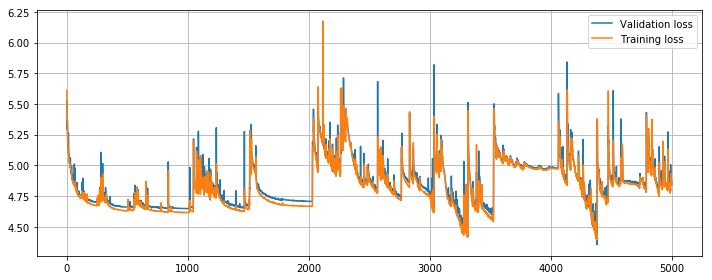

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [17]:
autoencoder.load_weights(weight_path)

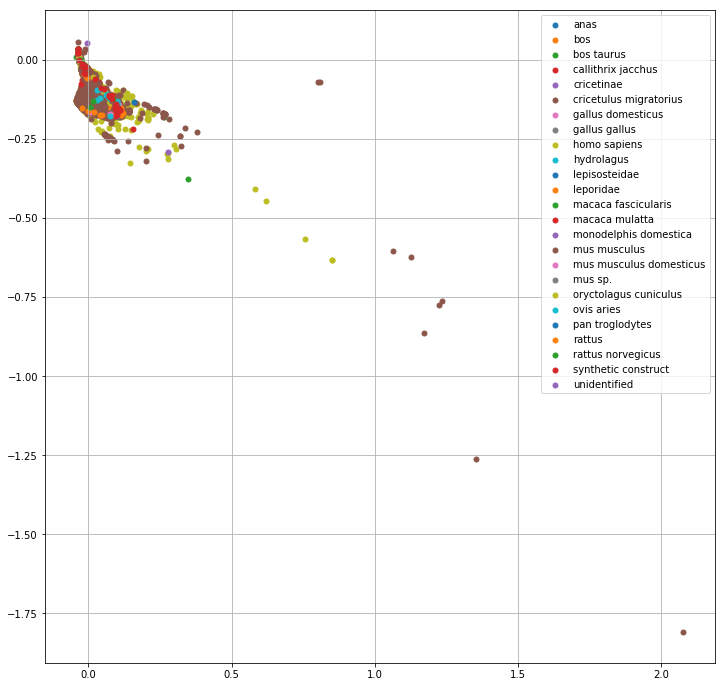

In [18]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [19]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,-0.036958,0.034972,-0.100725,-0.038604,-0.050839,0.056860,...,-0.079976,-0.011134,0.062829,0.039766,0.065934,0.005641,-0.087677,-0.232456,-0.061823,0.002030
P3,73.982970,0.130358,NaN,NaN,-0.036102,0.025797,-0.093849,-0.031512,-0.051021,0.056873,...,-0.070766,-0.015038,0.055648,0.031941,0.049530,0.000879,-0.095059,-0.215754,-0.058983,0.006552
P4,64.326010,0.060344,NaN,NaN,0.053319,-0.090649,-0.072106,-0.034659,-0.077778,0.062256,...,-0.041445,0.000891,0.019565,-0.002477,-0.020454,-0.022991,-0.090388,-0.120711,-0.109693,0.008423
P6,74.192370,0.036953,NaN,NaN,0.098643,-0.165019,-0.064401,-0.022163,-0.095146,0.063259,...,0.014158,-0.000316,-0.014319,0.019736,-0.005934,-0.055245,-0.115744,-0.100963,-0.124833,0.040666
P9,72.899025,0.085337,NaN,NaN,0.113132,-0.158423,-0.078925,-0.041143,-0.092749,0.063864,...,-0.001281,-0.006561,-0.014965,0.009145,-0.006866,-0.058204,-0.107987,-0.088945,-0.137545,0.032512


In [25]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [26]:
norm_variance = [np.var(X[:, x] / abs(np.mean(X[:,x]))) for x in range(X.shape[1])]

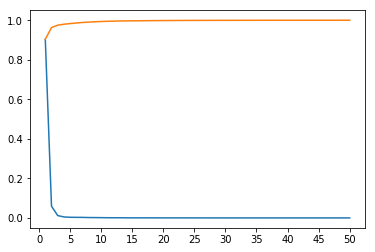

In [27]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [28]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :5]

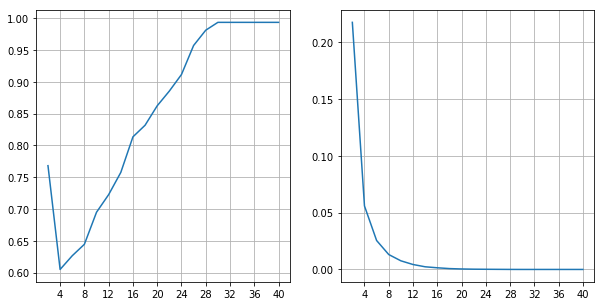

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for k in range(2, 41, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    s_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
    i_scores.append(kmeans.inertia_)
ax[0].plot(range(2, 41, 2), s_scores)
ax[1].plot(range(2, 41, 2), i_scores)
ax[0].grid()
ax[1].grid()

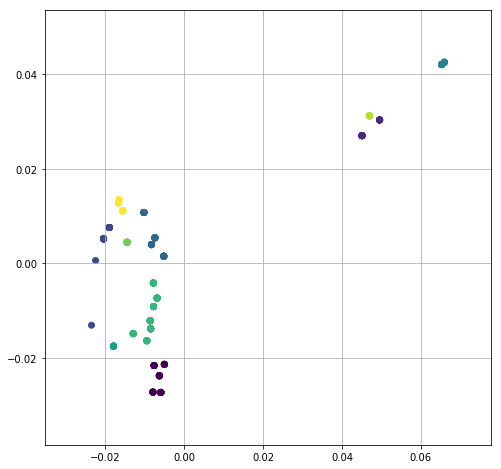

In [31]:
N_CLUSTERS = 10

kmeans = KMeans(N_CLUSTERS, random_state=0)
kmeans.fit(X)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X))
plt.grid()

/home/gil/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


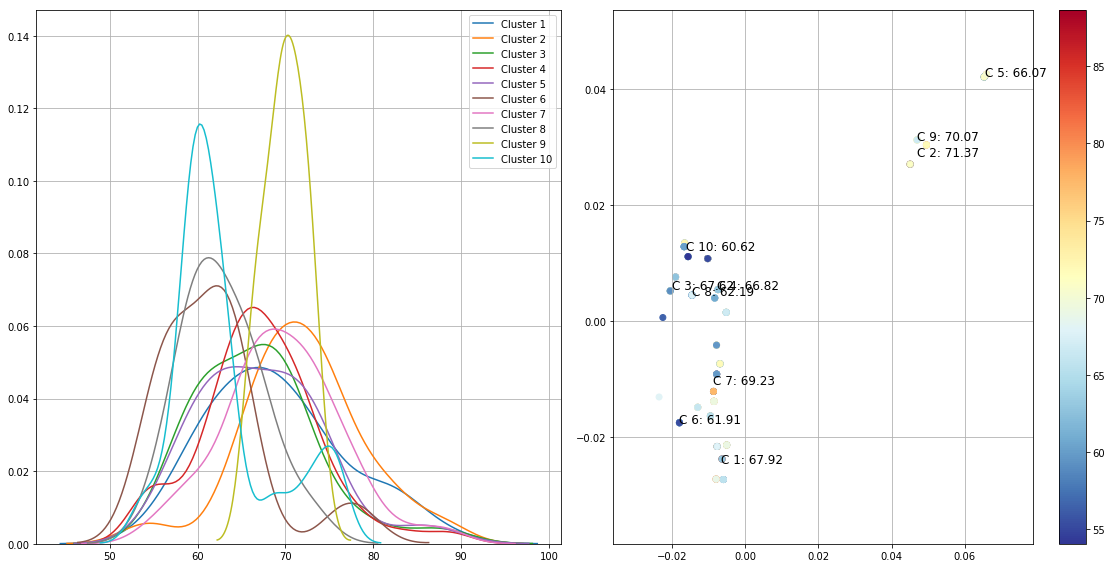

In [33]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(X) 
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(N_CLUSTERS):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()